In [1]:
# from optimal_transport import compute_optimal_transport, OptimalTransport

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
# import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

%matplotlib inline

import ot
import ot.plot

def ricker_func(t, t0, sigma):
    t = t-t0
    f = (1 - np.power(t,2) / (sigma**2)) * np.exp(-1 * np.power(t,2)/(2*sigma**2))
    return f

def compute_optimal_transport(M, r, c, lam, epsilon=1e-5):
    """
    Computes the optimal transport matrix and Slinkhorn distance using the
    Sinkhorn-Knopp algorithm

    Inputs:
        - M : cost matrix (n x m)
        - r : vector of marginals (n, )
        - c : vector of marginals (m, )
        - lam : strength of the entropic regularization
        - epsilon : convergence parameter

    Output:
        - P : optimal transport matrix (n x m)
        - dist : Sinkhorn distance
    """
    n, m = M.shape
    P = np.exp(- lam * M)
    P /= P.sum()
    u = np.zeros(n)
    # normalize this matrix
    while np.max(np.abs(u - P.sum(1))) > epsilon:
        u = P.sum(1)
        P *= (r / u).reshape((-1, 1))
        P *= (c / P.sum(0)).reshape((1, -1))
    return P, np.sum(P * M)

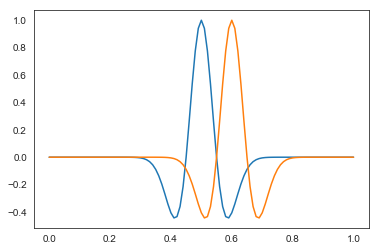

In [20]:
Nt = 101
dt = 0.01
t = np.linspace(0,1,Nt)

# f = np.sin(2*np.pi*2*t)
# g = np.sin(2*np.pi*2*(t-0.1))
# g = np.sin(2*np.pi*2.5*t) * 2 + np.cos(2*np.pi*1.2)

f = ricker_func(t, 0.5, 0.05)
g = ricker_func(t, 0.6, 0.05)

ff = np.ones(Nt) / Nt
gg = np.ones(Nt) / Nt
plt.figure(1)
plt.plot(t,f,t,g)

In [21]:
def OT_metric(f, g, lamb=10, mode=1):
    Nt = f.size
    ff = np.ones(Nt) / Nt
    gg = np.ones(Nt) / Nt
    
    f_hat = np.fft.fft(f)
    g_hat = np.fft.fft(g)

    if mode == 1:
        M = np.zeros([Nt,Nt])
        for i in range(0,Nt):
            for j in range(0,Nt):
                M[i,j] = np.abs(f_hat[i] - g_hat[j])**2
    elif mode == 2:
        # cost matrix: angle
        f_ang = np.arctan2(np.real(f_hat), np.imag(f_hat)) + np.pi;
        g_ang = np.arctan2(np.real(g_hat), np.imag(g_hat)) + np.pi;
        M = np.zeros([Nt,Nt])
        for i in range(0,Nt):
            for j in range(0,Nt):
                M[i,j] = np.abs(f_ang[i] - g_ang[j])**2      
    elif mode == 3:
        f_e = np.abs(f_hat);
        g_e = np.abs(g_hat);
        M = np.zeros([Nt,Nt])
        for i in range(0,Nt):
            for j in range(0,Nt):
                M[i,j] = np.abs(f_e[i] - g_e[j])**2
    else:
        f_ang = np.arctan2(np.real(f_hat), np.imag(f_hat)) + np.pi;
        g_ang = np.arctan2(np.real(g_hat), np.imag(g_hat)) + np.pi;
        M_ang = np.zeros([Nt,Nt])
        for i in range(0,Nt):
            for j in range(0,Nt):
                M_ang[i,j] = np.abs(f_ang[i] - g_ang[j])**2
        f_e = np.abs(f_hat);
        g_e = np.abs(g_hat);
        M_e = np.zeros([Nt,Nt])
        for i in range(0,Nt):
            for j in range(0,Nt):
                M_e[i,j] = np.abs(f_e[i] - g_e[j])**2
        k = mode
        M = M_ang + k * M_e

    P, d = compute_optimal_transport(M, ff, gg, lamb);
    return d

### L2 difference

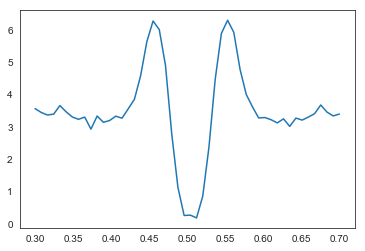

In [23]:
g = ricker_func(t, 0.5, 0.05)

N = 50
shift = np.linspace(0.3, 0.7, N)
misfit = np.zeros(N)

for i in range(N):
    f = ricker_func(t, shift[i], 0.05)
    misfit[i] = OT_metric(f, g, lamb=1, mode=1)

plt.plot(shift, misfit)

### Phase difference

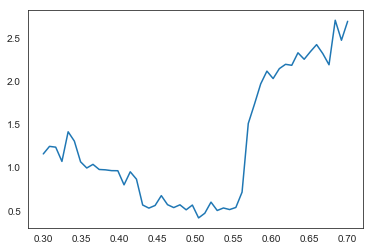

In [24]:
g = ricker_func(t, 0.5, 0.05)

N = 50
shift = np.linspace(0.3, 0.7, N)
misfit = np.zeros(N)

for i in range(N):
    f = ricker_func(t, shift[i], 0.05)
    misfit[i] = OT_metric(f, g, lamb=1, mode=2)

plt.plot(shift, misfit)

### Energy difference

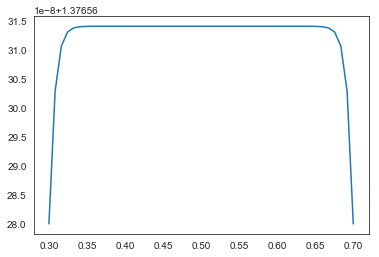

In [28]:
g = ricker_func(t, 0.5, 0.05)

N = 50
shift = np.linspace(0.3, 0.7, N)
misfit = np.zeros(N)

for i in range(N):
    f = ricker_func(t, shift[i], 0.05)
    misfit[i] = OT_metric(f, g, lamb=0.1, mode=3)

plt.plot(shift, misfit)

### Phase + energy difference

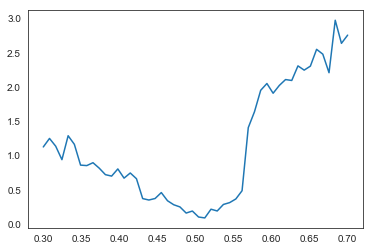

In [29]:
g = ricker_func(t, 0.5, 0.05)

N = 50
shift = np.linspace(0.3, 0.7, N)
misfit = np.zeros(N)

for i in range(N):
    f = ricker_func(t, shift[i], 0.05)
    misfit[i] = OT_metric(f, g, lamb=10, mode=0.5)

plt.plot(shift, misfit)